In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[3], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
np.random.seed(100)

4 Physical GPUs, 1 Logical GPU


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
latent_dim = 50
base_window_size = 10
Fs = 25
n_timesteps = base_window_size*Fs
n_channels = 3

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



encoder_inputs = keras.Input(shape=(n_timesteps, n_channels))

x = layers.Conv1D(100, 20, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.GRU(128,return_sequences=True,activation='tanh')(x)
x = layers.Conv1D(100, 20, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool1D(2)(x)
x = layers.Dropout(.5)(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(20, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(5*125, activation="relu")(latent_inputs)
x = layers.Reshape((125, 5))(x)
x = layers.Conv1DTranspose(125, 125, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv1DTranspose(125, 125, activation="relu", strides=2, padding="same")(x)
x = layers.GRU(10,return_sequences=True,activation='tanh')(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling1D(2,strides=1,padding='same')(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling1D(2,strides=1,padding='same')(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling1D(2,strides=1,padding='same')(x)
x = layers.GRU(n_channels,return_sequences=True,activation='tanh')(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, x, name="decoder")
# decoder = get_generator_model(latent_size=latent_dim)
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            aa = keras.losses.mean_absolute_error(data, reconstruction)
            reconstruction_loss = tf.reduce_sum(tf.reduce_mean(aa))
            print(reconstruction_loss.shape)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            total_loss = reconstruction_loss + kl_loss
#             + .1* kl_loss
#             + kl_loss
        print(total_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
import pickle
import numpy as np
import pandas as pd
X,y = pickle.load(open('./data/10/walking_all_data1.p','rb'))
X = np.concatenate(X[:10])
X.shape

In [ ]:
from scipy.stats import skew,kurtosis
def get_features(a):
    return np.array(list(np.mean(a,axis=0))+list(np.std(a,axis=0))+list(np.percentile(a,80,axis=0))+
list(np.percentile(a,20,axis=0))+list(skew(a,axis=0))+list(kurtosis(a,axis=0)))

In [ ]:
from joblib import Parallel,delayed

In [ ]:
X_features = Parallel(n_jobs=20,verbose=2)(delayed(get_features)(a) for a in X)

In [ ]:
X_features = np.array(X_features)

In [ ]:
.5*X_features.shape[1]*np.log(2*np.pi*np.e)*np.linalg.det(np.cov(X_features.T))

In [ ]:
np.linalg.det(np.cov(X_features[:,:3].T))

In [ ]:
from scipy.stats import norm
norm.fit(X_features)

In [ ]:
X[X>2] = 2
X[X<-2] = -2


In [ ]:
X = X/2

In [ ]:
# X = X[:,:,:1]
X.shape

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X, epochs=300, batch_size=100)

In [ ]:
z_sample = np.array([[xi, yi]])
x_decoded = vae.decoder.predict(z_sample)

In [ ]:
z_sample = vae.encoder.predict(X[:10])[0]

In [ ]:
z_sample.shape

In [ ]:
x_decoded = vae.decoder.predict(z_sample)

In [ ]:
x_decoded.shape

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x_decoded[8])
plt.plot(X[8])

In [ ]:
import shutil

In [ ]:
import pickle
import os

In [ ]:
directory = './results/walking_multiple/'

In [ ]:
results = []
for f in os.listdir(directory):
    df = pickle.load(open(directory+f,'rb'))
    results.append(df)

In [ ]:
import pandas as pd

In [ ]:
pickle.dump(pd.concat(results),open('./data/walking_multiple_iterations.p','wb'))

In [2]:
import tensorflow as tf
import pickle

In [3]:
model = tf.keras.models.load_model('./models/10/walking/120/300persons.hdf5')
final_model = tf.keras.models.Model(model.input,model.layers[-3].output)
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_94_input (InputLayer) [(None, 250, 3)]          0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 250, 128)          896       
_________________________________________________________________
max_pooling1d_94 (MaxPooling (None, 125, 128)          0         
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 125, 128)          32896     
_________________________________________________________________
max_pooling1d_95 (MaxPooling (None, 62, 128)           0         
_________________________________________________________________
activation_47 (Activation)   (None, 62, 128)           0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 62, 128)           0     

In [4]:
users = pickle.load(open('./models/10/walking/120/300user_dict.p','rb'))

In [5]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
X,y = pickle.load(open('./data/10/walking_all_data1.p','rb'))
y_participant = []
features = []
for i in range(len(X)):
    if len(X[i])<1100:
        continue
    y_participant.extend([y[i]]*len(X[i])) 
    features.append(PCA(n_components=300).fit_transform(final_model.predict(X[i])))
    print(features[-1].shape,end=',')
y = np.array(y_participant)
X = np.concatenate(X)

(1392, 300),(3416, 300),(1707, 300),(2658, 300),(6000, 300),(1213, 300),(3858, 300),(6000, 300),(2886, 300),(2486, 300),(6000, 300),(3025, 300),(4000, 300),(1813, 300),(2165, 300),(1689, 300),(4003, 300),(2298, 300),(1547, 300),(6000, 300),(1387, 300),(3276, 300),(2594, 300),(1688, 300),(4680, 300),(3135, 300),(1159, 300),(2384, 300),(1393, 300),(2895, 300),(2531, 300),(2365, 300),(1743, 300),(1961, 300),(1355, 300),(2001, 300),(1518, 300),(2378, 300),(2578, 300),(1991, 300),(1483, 300),(3488, 300),(1458, 300),(1769, 300),(3315, 300),(2551, 300),(3818, 300),(2116, 300),(3731, 300),(5282, 300),(3488, 300),(6000, 300),(2001, 300),(1754, 300),(2224, 300),(2997, 300),(3099, 300),(2434, 300),(2944, 300),(1602, 300),(1775, 300),(2284, 300),(1106, 300),(3001, 300),(2363, 300),(4581, 300),(1540, 300),(1196, 300),(1650, 300),(1850, 300),(1145, 300),(2291, 300),(1907, 300),(1798, 300),(3087, 300),(2791, 300),(1221, 300),(2104, 300),(1213, 300),(1954, 300),(2188, 300),(1618, 300),(5056, 300),(271

In [6]:
features = np.concatenate(features)

In [7]:
features1 = features.copy()

In [8]:
features = PCA(n_components=300).fit_transform(features1)

In [9]:
X.shape,y.shape,features.shape

((660863, 250, 3), (575593,), (575593, 300))

In [10]:
features.shape

(575593, 300)

In [11]:
unique_users = np.unique(list(users.keys()))
user_df =pd.DataFrame({'user':np.unique(y)})
index_df = pd.DataFrame({'user':y,'index':np.arange(len(y))})
n_users = np.arange(1,10,1)
n_iter = 80

def get_average_entropy(n_user,n_iter):
    result = []
    for k in range(n_iter):
        temp_users = np.unique(user_df.sample(n_user,replace=False)['user'].values)
    #     print(temp_users)
        index = index_df[index_df.user.isin(temp_users)]['index'].values
        temp_feature = features[index]
        d  = 300
        entropy = .5*np.log(np.linalg.det(np.cov(temp_feature[:,:d].T))) + (d/2)*(1+np.log(2*np.pi))
        result.append(entropy)
    return np.array([n_user,np.mean(result)])
from joblib import Parallel,delayed
result = []
for i in range(1,200,20):
    entropies = Parallel(n_jobs=20,verbose=2)(delayed(get_average_entropy)(n_user,n_iter) for i,n_user in enumerate(range(i,i+20)))
    print(entropies)
    result.extend(entropies)
    pickle.dump(result,open('./data/entropies3.p','wb'))
#     result = []
#     for k in range(n_iter):
#         temp_users = np.unique(user_df.sample(n_user,replace=False)['user'].values)
#     #     print(temp_users)
#         index = index_df[index_df.user.isin(temp_users)]['index'].values
#         temp_feature = features[index]
#         d  = 241
#         entropy = .5*np.log(np.linalg.det(np.cov(temp_feature[:,:d].T))) + (d/2)*(1+np.log(2*np.pi))
#         result.append(entropy)
#     print(n_user,np.mean(result))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    7.6s remaining:   43.2s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   24.2s remaining:   10.4s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   30.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([  1., -inf]), array([  2., -inf]), array([  3., -inf]), array([  4.        , 124.09383476]), array([  5.        , 119.82604042]), array([  6.       , 120.0474591]), array([  7.        , 121.22262395]), array([  8.       , 121.8283902]), array([  9.        , 123.87496932]), array([ 10.        , 123.78836345]), array([ 11.        , 122.37324381]), array([ 12.        , 123.38212417]), array([ 13.        , 120.84381517]), array([ 14.        , 122.52007732]), array([ 15.        , 121.82836054]), array([ 16.        , 123.52004581]), array([ 17.        , 124.55741838]), array([ 18.        , 120.70390381]), array([ 19.        , 122.63062482]), array([ 20.       , 123.8311133])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   42.9s remaining:  4.0min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  1.1min remaining:   28.5s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 21.        , 123.64822439]), array([ 22.        , 123.57664468]), array([ 23.        , 122.46296241]), array([ 24.        , 123.77523039]), array([ 25.        , 122.10990388]), array([ 26.        , 122.21767128]), array([ 27.        , 125.10137069]), array([ 28.        , 121.33298407]), array([ 29.        , 121.98967737]), array([ 30.        , 120.95866804]), array([ 31.        , 123.87185393]), array([ 32.       , 123.2407012]), array([ 33.        , 123.15825184]), array([ 34.        , 121.36588984]), array([ 35.        , 123.10666754]), array([ 36.        , 122.89543255]), array([ 37.        , 124.93271239]), array([ 38.        , 121.70618202]), array([ 39.        , 122.33505743]), array([ 40.        , 123.19075463])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  1.4min remaining:  7.7min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  1.8min remaining:   46.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.0min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 41.        , 123.55271602]), array([ 42.       , 121.9074082]), array([ 43.        , 121.14395557]), array([ 44.        , 122.67609705]), array([ 45.        , 122.73808123]), array([ 46.        , 123.16358393]), array([ 47.        , 121.76652948]), array([ 48.        , 122.60358027]), array([ 49.        , 122.18943347]), array([ 50.       , 122.8874514]), array([ 51.        , 123.88472903]), array([ 52.        , 121.93443066]), array([ 53.        , 123.24549021]), array([ 54.        , 121.38868297]), array([ 55.        , 123.03054819]), array([ 56.        , 122.38131536]), array([ 57.        , 123.28776124]), array([ 58.       , 122.3317258]), array([ 59.        , 121.77522954]), array([ 60.        , 122.74536125])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  1.9min remaining: 10.7min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  2.5min remaining:  1.1min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.7min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 61.       , 122.1536612]), array([ 62.        , 123.10560918]), array([ 63.        , 121.80518016]), array([ 64.        , 123.02424197]), array([ 65.        , 122.13355997]), array([ 66.        , 122.27777181]), array([ 67.        , 122.74467715]), array([ 68.        , 122.86725573]), array([ 69.        , 122.75258838]), array([ 70.        , 122.67225043]), array([ 71.        , 122.34039271]), array([ 72.        , 122.13820862]), array([ 73.        , 122.40427432]), array([ 74.        , 122.01329409]), array([ 75.        , 122.70370946]), array([ 76.        , 122.53927674]), array([ 77.        , 121.94960523]), array([ 78.        , 122.54555784]), array([ 79.        , 122.00692862]), array([ 80.       , 121.9276797])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  2.2min remaining: 12.3min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  3.2min remaining:  1.4min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  3.4min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 81.        , 121.96448592]), array([ 82.        , 122.15360756]), array([ 83.        , 122.03767828]), array([ 84.        , 122.34129759]), array([ 85.        , 123.44432317]), array([ 86.       , 122.3580885]), array([ 87.        , 122.77093659]), array([ 88.        , 122.04675859]), array([ 89.        , 122.93947856]), array([ 90.        , 122.77957854]), array([ 91.        , 122.50463425]), array([ 92.        , 122.67138823]), array([ 93.        , 122.56694415]), array([ 94.        , 122.71720697]), array([ 95.        , 122.54262808]), array([ 96.        , 122.75987593]), array([ 97.        , 122.08031523]), array([ 98.        , 122.60341499]), array([ 99.        , 122.96673273]), array([100.        , 122.43297996])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  2.7min remaining: 15.6min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  4.0min remaining:  1.7min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  4.2min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([101.        , 122.67860123]), array([102.        , 122.01043557]), array([103.        , 122.05182338]), array([104.        , 122.55820249]), array([105.        , 122.58823319]), array([106.        , 122.96343521]), array([107.        , 122.56584297]), array([108.        , 122.03791873]), array([109.        , 123.15012349]), array([110.        , 122.44665155]), array([111.        , 122.11425792]), array([112.        , 122.82930432]), array([113.       , 123.3647061]), array([114.        , 122.84694793]), array([115.        , 122.23965328]), array([116.        , 123.05466792]), array([117.        , 123.41613056]), array([118.        , 123.03799309]), array([119.        , 122.53769606]), array([120.        , 122.89262519])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  3.3min remaining: 18.7min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  4.7min remaining:  2.0min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  4.9min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([121.        , 122.54187607]), array([122.        , 123.05069814]), array([123.        , 122.52655004]), array([124.        , 122.55954819]), array([125.        , 122.50087569]), array([126.        , 122.98544059]), array([127.        , 122.87205248]), array([128.      , 122.713563]), array([129.        , 122.99959802]), array([130.       , 123.0597541]), array([131.        , 122.51128071]), array([132.        , 122.70765264]), array([133.        , 123.02086409]), array([134.        , 122.39830829]), array([135.        , 122.91096694]), array([136.       , 122.6382629]), array([137.        , 122.42368848]), array([138.        , 122.36637007]), array([139.        , 122.38855838]), array([140.        , 122.61777828])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  3.7min remaining: 20.8min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  5.4min remaining:  2.3min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  5.6min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([141.        , 122.48138623]), array([142.        , 122.60046986]), array([143.        , 122.64490669]), array([144.        , 122.73064954]), array([145.        , 122.54966821]), array([146.        , 122.68074842]), array([147.        , 121.86937508]), array([148.        , 122.41303019]), array([149.        , 122.72328085]), array([150.        , 122.63737344]), array([151.        , 122.49125481]), array([152.        , 122.94198084]), array([153.        , 122.27761324]), array([154.        , 122.59608662]), array([155.        , 122.60324084]), array([156.        , 122.93392434]), array([157.        , 122.62367575]), array([158.        , 122.58214564]), array([159.        , 122.79831159]), array([160.        , 122.95500673])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  5.0min remaining: 28.5min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  6.1min remaining:  2.6min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  6.5min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([161.        , 122.56329006]), array([162.        , 122.51434686]), array([163.        , 122.82901041]), array([164.        , 122.53971135]), array([165.        , 122.17640512]), array([166.        , 122.59416733]), array([167.        , 122.41810716]), array([168.        , 122.61256702]), array([169.        , 122.59217598]), array([170.        , 122.62349194]), array([171.        , 123.17415584]), array([172.        , 122.49373263]), array([173.        , 122.54105266]), array([174.        , 122.52330697]), array([175.        , 122.63858393]), array([176.        , 122.47862634]), array([177.        , 122.70789567]), array([178.        , 122.69611978]), array([179.        , 122.50801777]), array([180.        , 122.52030982])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  5.6min remaining: 31.6min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  7.0min remaining:  3.0min


[array([181.        , 122.76278887]), array([182.        , 122.46343244]), array([183.        , 122.64311971]), array([184.        , 122.64850766]), array([185.        , 122.50588996]), array([186.        , 122.61070681]), array([187.        , 122.72513754]), array([188.       , 122.4983677]), array([189.        , 122.70706429]), array([190.        , 122.73938771]), array([191.        , 123.01045941]), array([192.        , 122.74370017]), array([193.        , 122.76116575]), array([194.        , 122.55640644]), array([195.        , 122.51747923]), array([196.        , 122.59029375]), array([197.        , 122.53960053]), array([198.        , 122.52942943]), array([199.       , 122.6383292]), array([200.        , 122.65247003])]


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  7.1min finished


In [44]:
entropies = pickle.load(open('./data/entropies2.p','rb'))

In [45]:
entropies= np.array(entropies)

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
entropies.shape

(200, 2)

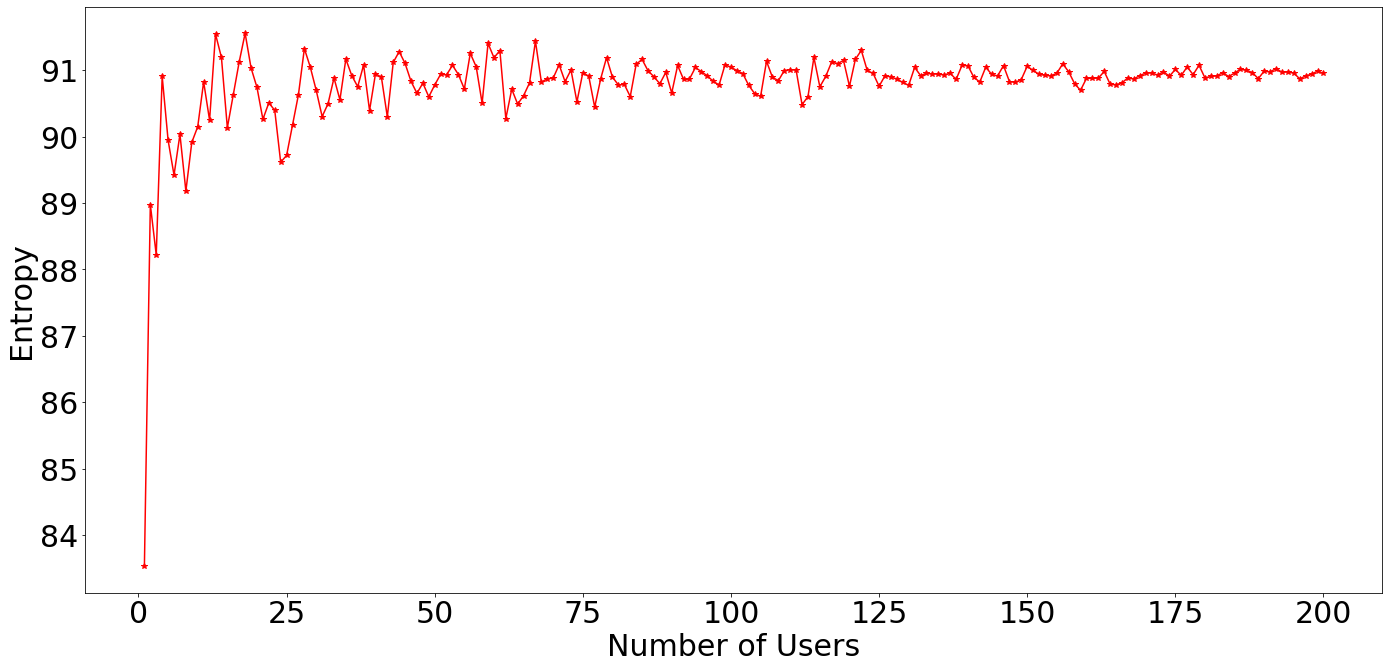

In [48]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':30})
plt.plot(entropies[:,0],entropies[:,1],'r-*')
plt.xlabel('Number of Users')
plt.ylabel('Entropy')
plt.tight_layout()
plt.savefig('./images/entropy2.png')
plt.show()